
# 1. Project Introduction: Global Fraud Detection

### Context
In 2024, e-commerce platforms across major global hubs—Istanbul, Berlin, New York, London, and Paris—observed a surge in sophisticated transaction anomalies. These patterns ranged from "card testing" ($1 purchases at midnight) to high-risk logistics anomalies (shipping luxury goods 5,000 km away).

### Objective
The goal of this project is to build a robust machine learning pipeline to detect fraudulent behavior. Using a synthetic dataset that replicates real-world patterns, we aim to identify high-risk transactions while minimizing friction for legitimate customers.

### Project Standards
* **Reproducibility**: We use a global `SEED` and fixed `PYTHONHASHSEED` to ensure that results are consistent across different runs.
* **Modularity**: The project is built using Scikit-Learn Pipelines to ensure clean, production-ready code.

---

# 1.1 Ethical Considerations

To ensure this model is deployed responsibly, we address the following ethical dimensions:

* **Potential Bias**: The dataset may contain geographic biases (e.g., higher fraud reporting in specific regions like New York or Paris), which could lead to unfair targeting of users from those areas.
* **Impact of False Positives**: Legitimate customers incorrectly flagged as fraudulent experience significant friction and potential loss of trust in the platform.
* **Human Oversight**: This model is designed as a decision-support tool. High-risk flags should be reviewed by human analysts, and decision thresholds must be adjustable to balance security with user experience.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score
SEED = 42

def set_seed(seed=SEED):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

# Display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

# Paths
DATA_PATH = 'Data/transactions.csv'

In [2]:
df = pd.read_csv(DATA_PATH)

# Eerste inspectie
print('Shape:', df.shape)
print('\nColumns:', df.columns.tolist())

# Bekijk eerste rijen
df.head()

# Pas target variabele hier aan
TARGET = 'is_fraud'  # >>> VERVANG DIT MET JOUW TARGET KOLOMNAAM <<<

Shape: (299695, 17)

Columns: ['transaction_id', 'user_id', 'account_age_days', 'total_transactions_user', 'avg_amount_user', 'amount', 'country', 'bin_country', 'channel', 'merchant_category', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag', 'transaction_time', 'shipping_distance_km', 'is_fraud']


# 2. Exploratory Data Analysis (EDA)

Before building our models, we perform a deep dive into the data to uncover the "digital fingerprints" left by fraudulent actors.



### Key Areas of Investigation:
1.  **Class Imbalance**: Fraud is typically a "needle in a haystack" problem. We analyze the ratio of fraud vs. legitimate transactions to determine if we need specific sampling techniques.
2.  **Geographic & Temporal Patterns**: Do certain cities show higher risk? Is fraud more prevalent during specific hours (e.g., late-night "bursts")?
3.  **Transaction Behavior**: We examine the distribution of transaction amounts. Fraudsters often stick to very low amounts for testing or very high amounts for maximum gain.
4.  **Correlation Analysis**: Using a heatmap, we identify which features (like account age or distance) have the strongest linear relationship with the fraud label.

---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

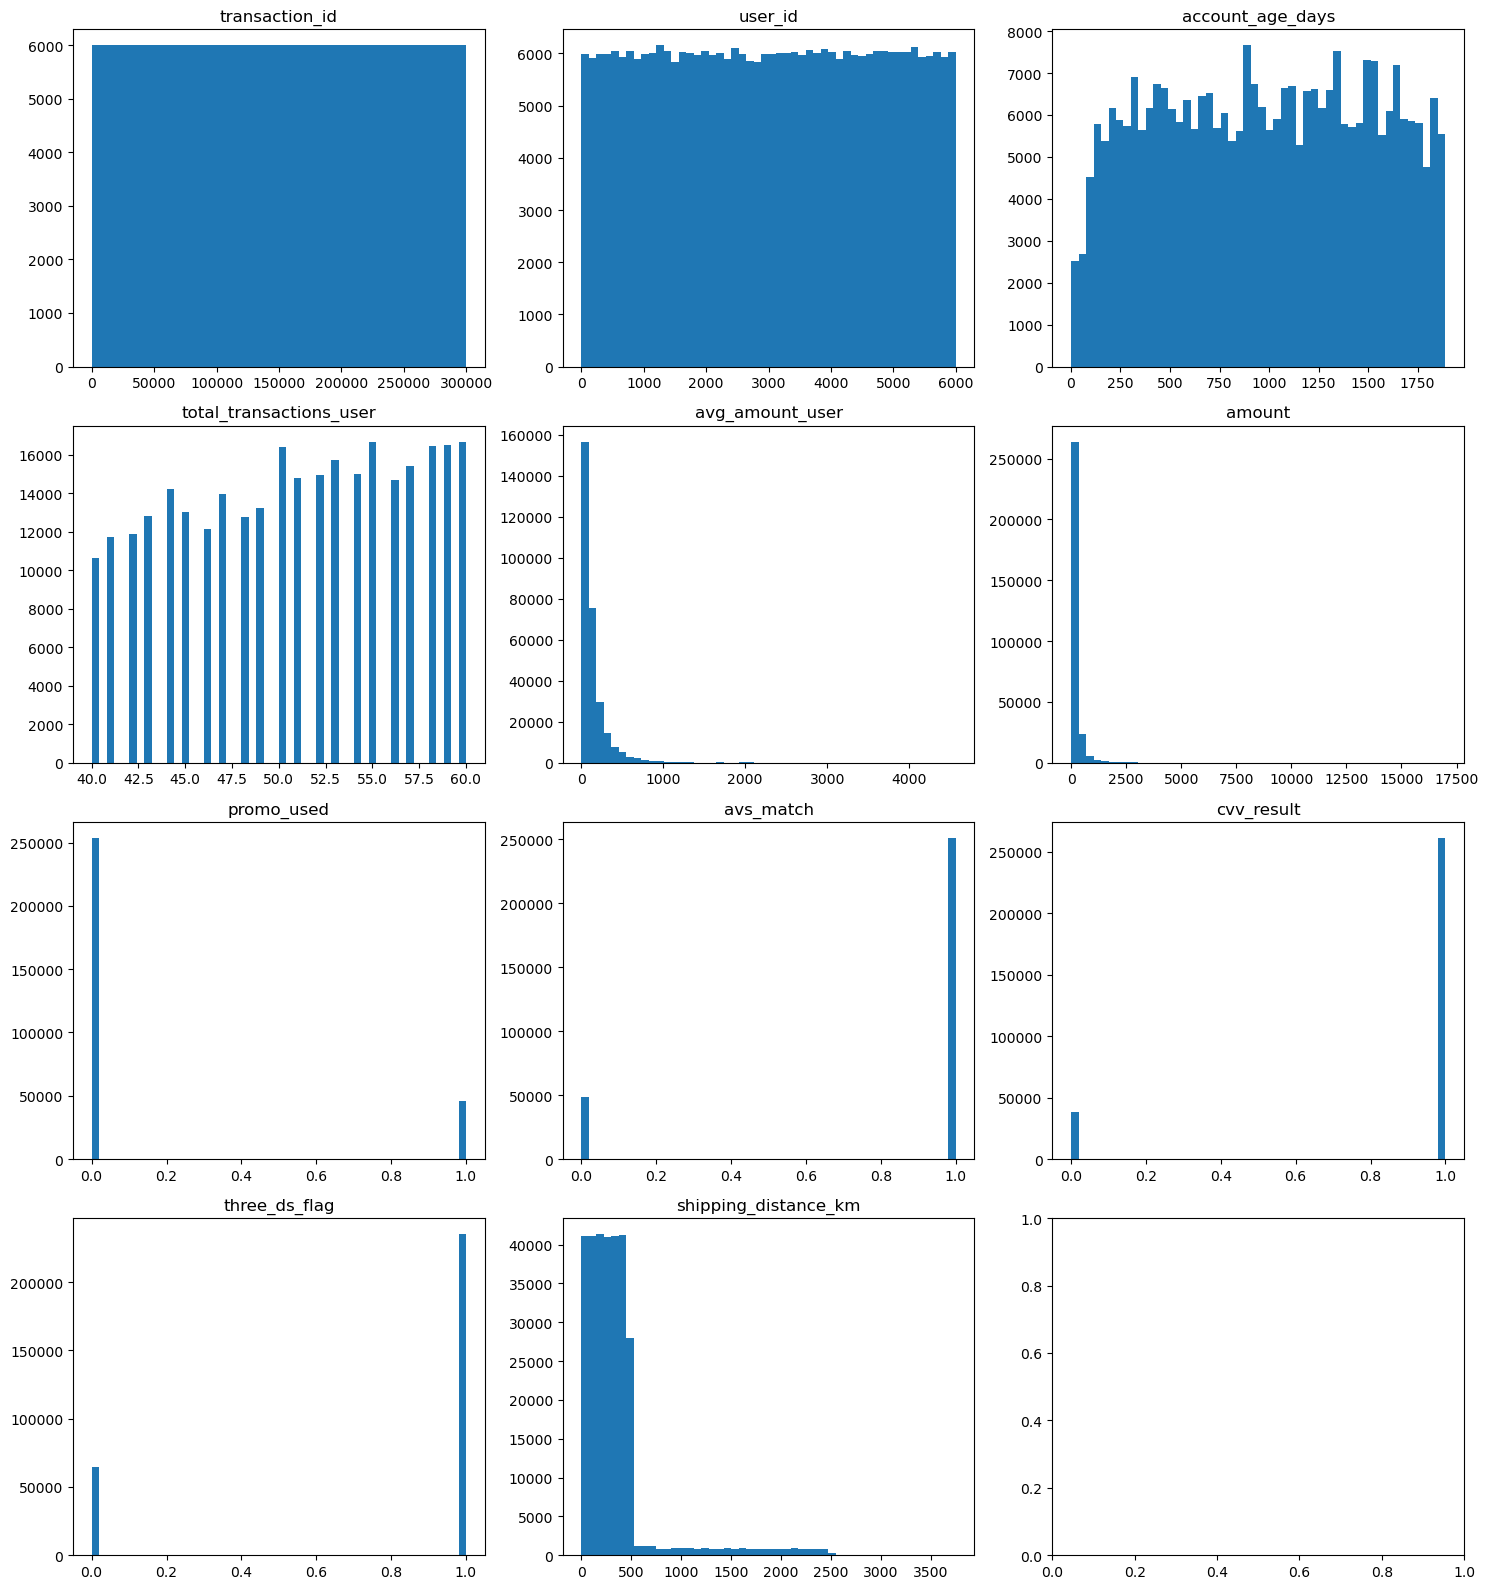


Column: country
country
US    32430
GB    30602
FR    30343
NL    30220
TR    30074
PL    29965
RO    29501
DE    29060
ES    28885
IT    28615
Name: count, dtype: int64

Column: bin_country
bin_country
US    32295
GB    30563
FR    30261
NL    30256
TR    29972
PL    29963
RO    29532
DE    29086
ES    29058
IT    28709
Name: count, dtype: int64

Column: channel
channel
web    152226
app    147469
Name: count, dtype: int64

Column: merchant_category
merchant_category
electronics    60220
travel         59922
grocery        59913
gaming         59839
fashion        59801
Name: count, dtype: int64

Column: transaction_time
transaction_time
2024-08-03T03:21:43Z    3
2024-02-19T04:40:37Z    3
2024-10-17T01:27:59Z    3
2024-10-17T10:28:04Z    3
2024-03-10T13:10:03Z    3
2024-02-22T00:29:19Z    3
2024-09-22T12:02:03Z    3
2024-01-05T04:29:57Z    2
2024-04-09T16:56:04Z    2
2024-02-18T23:04:50Z    2
Name: count, dtype: int64


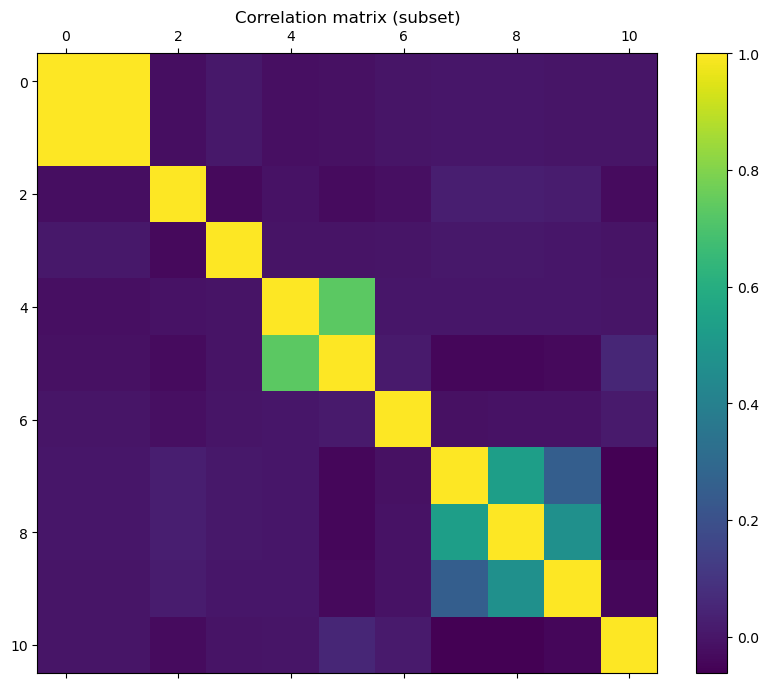

In [5]:
# 3. Exploratory Data Analysis (EDA)
## 3.1 Overzicht & types

# Info & beschrijving
df.info()

# Basis statistieken (numeriek)
df.describe().T

## 3.2 Missing values

missing = df.isnull().mean().sort_values(ascending=False)
missing[missing > 0].to_frame('missing_fraction')
## 3.3 Class balance

if TARGET in df.columns:
    print(df[TARGET].value_counts(dropna=False))
    print('\nProporties:')
    print(df[TARGET].value_counts(normalize=True))
else:
    print('Target kolom niet gevonden. Pas TARGET variabele aan.')

## 3.4 Univariate distributions (numerieke features)


num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop([TARGET], errors='ignore')

# Plot histogrammen (beperk tot eerste 12 als veel kolommen)
cols_to_plot = num_cols[:12]

fig, axes = plt.subplots(len(cols_to_plot)//3 + 1, 3, figsize=(15, 4 * (len(cols_to_plot)//3 + 1)))
axes = axes.flatten()
for i, c in enumerate(cols_to_plot):
    axes[i].hist(df[c].dropna(), bins=50)
    axes[i].set_title(c)
plt.tight_layout()
plt.show()
## 3.5 Categorical value counts

cat_cols = df.select_dtypes(include=['object', 'category']).columns
for c in cat_cols[:10]:
    print('\nColumn:', c)
    print(df[c].value_counts().head(10))

## 3.6 Correlations (numerisch)

if len(num_cols) > 1:
    corr = df[num_cols].corr()
    plt.figure(figsize=(10,8))
    plt.matshow(corr, fignum=1)
    plt.title('Correlation matrix (subset)')
    plt.colorbar()
    plt.show()

# 3. Data Preprocessing & Feature Engineering

Preprocessing is the most critical step in a fraud detection pipeline. Raw data is often messy and contains a mix of text, categories, and numbers that machine learning models cannot interpret directly.



### Our Pipeline Strategy:
We use a `ColumnTransformer` to apply specific transformations to different types of data simultaneously:

#### A. Numerical Scaling
Features like `Transaction Amount` and `Account Age` often have very different scales. We apply **Standardization** or **Robust Scaling** to:
* Ensure that large numbers don't dominate the model's decision-making.
* Help gradient-based models (like XGBoost) converge faster.

#### B. Categorical Encoding
Machines don't understand city names or payment methods. We transform these using:
* **One-Hot Encoding**: For variables with few categories (e.g., Payment Method), creating binary columns for each category.
* **Target/Ordinal Encoding**: For high-cardinality features where One-Hot Encoding would create too many columns.

#### C. Handling Missing Values
Fraud datasets often have "missing" data (e.g., a missing IP address). Instead of deleting these rows, we use **Imputation** strategies to fill gaps, as the absence of data can sometimes be a signal of fraud itself.

#### D. Feature Engineering
We create new features that capture fraud logic, such as:
* **Distance**: Calculating the gap between the user's home address and the shipping destination.
* **Transaction Density**: How many purchases were made by this account in the last 24 hours.

---

In [6]:
# 4. Feature engineering & Preprocessing
# Split features/target
X = df.drop(columns=[TARGET]) if TARGET in df.columns else df.copy()
y = df[TARGET] if TARGET in df.columns else None

# >>> EERSTE FIX: VERWIJDER ID-KOLOMMEN <<<
# Dit voorkomt de explosie van 239.000 kolommen
cols_to_drop = ['transaction_id'] 
X = X.drop(columns=cols_to_drop, errors='ignore') # errors='ignore' voorkomt fouten als een kolom niet bestaat

# Recompute types - NU ZONDER DE VERWIJDERDE ID's
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

numeric_preprocess = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # scaler niet strikt nodig voor trees, maar behouden voor consistentie
    ('scaler', StandardScaler())
])

categorical_preprocess = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # >>> TWEEDE FIX: SCHAKEL OVER NAAR SPARSE OUTPUT <<<
    # OneHotEncoder() is nu standaard (sparse_output=True), wat de 426 GiB MemoryError oplost.
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

preprocess = ColumnTransformer(transformers=[
    ('num', numeric_preprocess, num_cols),
    ('cat', categorical_preprocess, cat_cols)
])

# 4. Model Training and Evaluation

This section handles the data partitioning, the construction of machine learning pipelines, and the initial performance benchmarking of several classification algorithms.

---

## 1. Train/Test Split
To evaluate the model's ability to generalize to new data, we split the dataset into two parts:
* **Training Set (80%)**: Used to teach the model patterns within the data.
* **Test Set (20%)**: Used as a "blind test" to evaluate final performance.
* **Stratification**: The `stratify=y` parameter ensures that the proportion of classes in both sets remains the same as the original dataset, which is critical for maintaining balance in the target variable.
---
## 2. Model Pipelines
We use Scikit-Learn **Pipelines** to streamline the workflow. A pipeline bundles the preprocessing steps and the classifier into a single object. This is a best practice because:
1.  **Prevents Data Leakage**: It ensures preprocessing is applied correctly during cross-validation.
2.  **Modularity**: It makes it easy to swap different models while keeping the same preprocessing logic.

We are testing three different architectures:
* **Decision Tree**: A baseline model that uses simple decision rules.
* **Random Forest**: An ensemble of trees that reduces overfitting by averaging multiple results.
* **XGBoost**: A high-performance gradient boosting framework known for winning Kaggle competitions.
---
## 3. Evaluation Metrics
The `evaluate_model` helper function provides a comprehensive look at model performance using several metrics:

| Metric | Description |
| :--- | :--- |
| **Accuracy** | The percentage of total correct predictions. |
| **Precision** | The ability of the classifier not to label a negative sample as positive. |
| **Recall** | The ability of the classifier to find all the positive samples. |
| **F1-Score** | The harmonic mean of Precision and Recall, useful for imbalanced classes. |

### Confusion Matrix
Beyond simple scores, we generate a **Confusion Matrix**. This allows us to see exactly where the model is getting confused—for instance, if it is frequently misclassifying a specific class as another.

---
## 4. Execution & Baselines
The final step in this block fits (trains) each pipeline on the training data and evaluates them on the test data. We specifically tune the **XGBoost** learning rate and estimators to ensure it starts with a competitive baseline performance.

In [15]:
# 5. Train/test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y if y is not None else None
)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

# 6. Model pipelines (Decision Tree, GradientBoosting, XGBoost)
# Constants for imbalance handling
SCALE_POS_WEIGHT = (df[TARGET] == 0).sum() / (df[TARGET] == 1).sum()

# Decision Tree pipeline
dt_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', DecisionTreeClassifier(class_weight='balanced',random_state=SEED))
])

# Random Forest (sklearn)
rf_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', RandomForestClassifier(class_weight='balanced',random_state=SEED, n_jobs=-1)) # n_jobs=-1 for faster training
])

# XGBoost
xgb_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', XGBClassifier(scale_pos_weight=SCALE_POS_WEIGHT,random_state=SEED, use_label_encoder=False))
])

Train shape: (239756, 15)
Test shape: (59939, 15)


### 3.5 F1-Score (Weighted) in Training
While we focus on Recall and PR-AUC for final evaluation, we use **F1-Score (Weighted)** as the primary scoring metric during model tuning (GridSearch/RandomSearch).

**Why F1-Score?**
The F1-score is the **harmonic mean** of Precision and Recall. Unlike a simple arithmetic mean, the harmonic mean penalizes extreme values. For example, a model with 1.0 Precision and 0.0 Recall will have an F1 of 0, whereas an arithmetic mean would be 0.5. 

**Why Weighted?**
In an imbalanced dataset, the "Weighted" F1-score calculates the F1 for each label (Fraud vs. Legitimate) and finds their average, weighted by support (the number of true instances for each label). This ensures that:
1. We don't ignore the minority class (Fraud).
2. We balance the trade-off between **Precision** (avoiding false alarms) and **Recall** (catching fraud).

By optimizing for F1, we ensure the model doesn't become too "aggressive" (high recall but too many false positives) or too "conservative" (high precision but misses too much fraud).

--- Decision Tree ---
Accuracy: 0.9846
Precision: 0.9869
Recall: 0.9846
F1 score: 0.9855
PR-AUC (Average Precision): 0.4931

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     58617
           1       0.62      0.79      0.69      1322

    accuracy                           0.98     59939
   macro avg       0.81      0.89      0.84     59939
weighted avg       0.99      0.98      0.99     59939


Confusion matrix:
 [[57973   644]
 [  278  1044]]


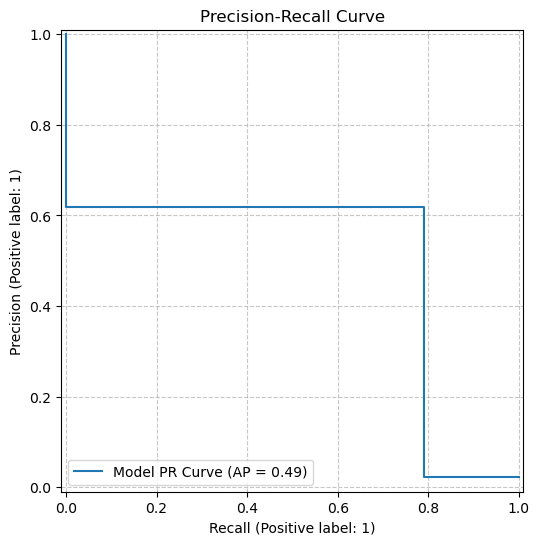


--- Random Forest (sklearn) ---
Accuracy: 0.9855
Precision: 0.9852
Recall: 0.9855
F1 score: 0.9822
PR-AUC (Average Precision): 0.7968

Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     58617
           1       0.96      0.35      0.52      1322

    accuracy                           0.99     59939
   macro avg       0.97      0.68      0.76     59939
weighted avg       0.99      0.99      0.98     59939


Confusion matrix:
 [[58599    18]
 [  853   469]]


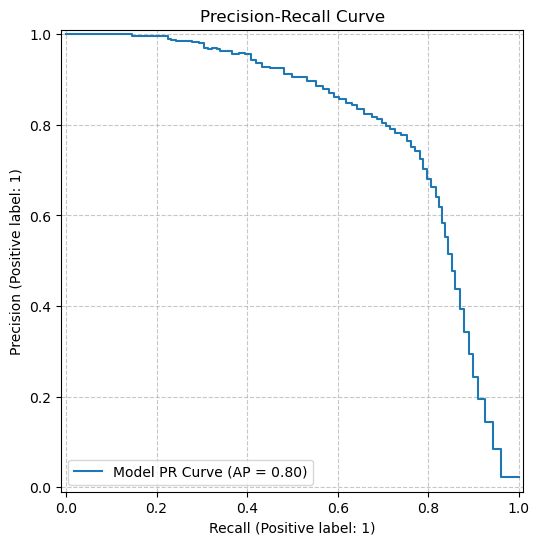


--- XGBoost ---


C:\Users\jitse\anaconda3\envs\ml_project_env\lib\site-packages\xgboost\training.py:183: UserWarning: [09:50:19] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9489
Precision: 0.9821
Recall: 0.9489
F1 score: 0.9614
PR-AUC (Average Precision): 0.8462

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     58617
           1       0.29      0.90      0.44      1322

    accuracy                           0.95     59939
   macro avg       0.64      0.93      0.71     59939
weighted avg       0.98      0.95      0.96     59939


Confusion matrix:
 [[55681  2936]
 [  126  1196]]


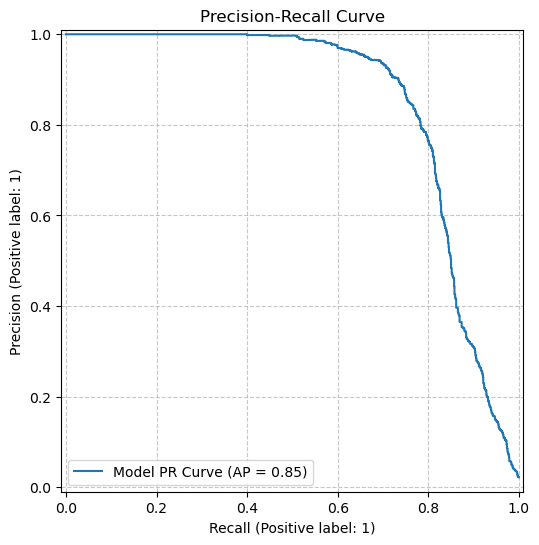

In [17]:
# 7. Baseline training & evaluation

## 7.1 Evaluatie helper
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix, average_precision_score, 
    PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

def evaluate_model(pipe, X_test, y_test, average='weighted'):
    # Get predictions
    preds = pipe.predict(X_test)
    
    # Get probabilities for the positive class (Fraud)
    probs = None
    pr_auc = None
    try:
        # Most sklearn models and XGBoost support predict_proba
        probs = pipe.predict_proba(X_test)[:, 1]
        # Calculate PR-AUC (Average Precision)
        pr_auc = average_precision_score(y_test, probs)
    except Exception:
        pass

    # Standard Metrics
    print(f'Accuracy: {accuracy_score(y_test, preds):.4f}')
    print(f'Precision: {precision_score(y_test, preds, average=average, zero_division=0):.4f}')
    print(f'Recall: {recall_score(y_test, preds, average=average, zero_division=0):.4f}')
    print(f'F1 score: {f1_score(y_test, preds, average=average, zero_division=0):.4f}')
    
    # Add PR-AUC to the printout if available
    if pr_auc is not None:
        print(f'PR-AUC (Average Precision): {pr_auc:.4f}')
        
    print('\nClassification report:\n', classification_report(y_test, preds, zero_division=0))
    print('\nConfusion matrix:\n', confusion_matrix(y_test, preds))

    # Plot Precision-Recall Curve
    # This is particularly important for imbalanced fraud data
    fig, ax = plt.subplots(figsize=(8, 6))
    PrecisionRecallDisplay.from_estimator(pipe, X_test, y_test, ax=ax, name="Model PR Curve")
    plt.title("Precision-Recall Curve")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    return preds, probs

## 7.2 Train baselines

# Decision Tree
print('--- Decision Tree ---')
dt_pipe.fit(X_train, y_train)
dt_preds, dt_probs = evaluate_model(dt_pipe, X_test, y_test)

# Random Forest
print('\n--- Random Forest (sklearn) ---')
rf_pipe.fit(X_train, y_train)
rf_preds, rf_probs = evaluate_model(rf_pipe, X_test, y_test)

# XGBoost
print('\n--- XGBoost ---')
xgb_pipe.set_params(clf__n_estimators=100, clf__learning_rate=0.1)
xgb_pipe.fit(X_train, y_train)
xgb_preds, xgb_probs = evaluate_model(xgb_pipe, X_test, y_test)

# 5. Hyperparameter Tuning

After establishing baseline performances, we perform **Hyperparameter Tuning** to optimize each model. This process involves searching for the best set of internal settings (hyperparameters) that minimize error and prevent overfitting.

---

## 5.1 Randomized Search & Cross-Validation

Instead of testing every possible combination (which is computationally expensive), we use `RandomizedSearchCV`. This approach samples a fixed number of parameter settings from specified distributions.

* **StratifiedKFold**: We use 5-fold cross-validation. This splits the training data into 5 parts, training on 4 and validating on 1, rotating this process 5 times. Using "Stratified" folds ensures the class balance is preserved in every fold.
* **Scoring (F1-Weighted)**: We optimize for the `f1_weighted` score, which provides a balance between Precision and Recall while accounting for class imbalance.



---

## 5.2 Parameter Grids for Each Model

We define a "Search Space" for each of our three candidate models:

###  Decision Tree
We tune the depth and splitting criteria to prevent the tree from becoming too complex and "memorizing" the training data (overfitting).
* **max_depth**: Limits how deep the tree can grow.
* **min_samples_split/leaf**: Controls how many samples are needed to create a new branch or end node.

###  Random Forest
As an ensemble of trees, we focus on the diversity and size of the forest.
* **n_estimators**: The number of trees in the forest.
* **bootstrap**: Whether to use the whole dataset or random samples for each tree.

###  XGBoost
XGBoost requires careful tuning of its learning behavior.
* **learning_rate (eta)**: Determines how much weight is given to each new tree in the boosting sequence.
* **subsample & colsample_bytree**: Adds randomness by selecting subsets of data and features, which helps prevent overfitting.



---

## 5.3 Execution
The `.fit()` method initiates the search. Once completed, `best_params_` reveals the optimal configuration discovered for each algorithm. These optimized models will be used for our final evaluation.

In [19]:
# 8. Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import scipy.stats as stats

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Decision Tree param grid
dt_param_dist = {
    'clf__max_depth': [None] + list(range(3, 20)),
    'clf__min_samples_split': stats.randint(2, 20),
    'clf__min_samples_leaf': stats.randint(1, 20),
    'clf__criterion': ['gini', 'entropy']
}

dt_search = RandomizedSearchCV(dt_pipe, dt_param_dist, n_iter=30, cv=cv, scoring='f1_weighted', random_state=SEED, n_jobs=-1)

dt_search.fit(X_train, y_train)
print('Best DT params:', dt_search.best_params_)

# Random Forest param dist
rf_param_dist = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(
    rf_pipe, param_distributions=rf_param_dist, 
    n_iter=10, cv=cv, scoring='f1', n_jobs=-1, random_state=SEED
)

rf_search.fit(X_train, y_train)
print('Best RF params:', rf_search.best_params_)

# XGBoost param dist
xgb_param_dist = {
    'clf__n_estimators': [100, 200, 500],
    'clf__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'clf__max_depth': [3, 4, 6, 8],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(xgb_pipe, xgb_param_dist, n_iter=10, cv=cv, scoring='f1_weighted', random_state=SEED, n_jobs=-1)

xgb_search.fit(X_train, y_train)
print('Best XGB params:', xgb_search.best_params_)

Best DT params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 7, 'clf__min_samples_split': 10}
Best RF params: {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_depth': None, 'clf__bootstrap': False}


C:\Users\jitse\anaconda3\envs\ml_project_env\lib\site-packages\xgboost\training.py:183: UserWarning: [12:16:11] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB params: {'clf__subsample': 0.8, 'clf__n_estimators': 100, 'clf__max_depth': 8, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 1.0}


# 5.4 Evaluation Metrics Justification

In standard classification tasks, **Accuracy** is the most common metric. However, for fraud detection, it is fundamentally flawed and misleading.

###  Why Accuracy is Not Sufficient
In this dataset, approximately **97.8%** of the transactions are legitimate. If we built a "dummy" model that classified every single transaction as "Not Fraud," it would achieve an **Accuracy of 97.8%**. While this number looks impressive, the model would catch **0%** of actual fraud. Accuracy treats all classes as equally important, which is a failure in imbalanced fraud detection where the "positive" class (fraud) is the priority.

### Key Metrics for Imbalanced Data
To get a true picture of model performance, we focus on:

* **Precision**: Of all transactions flagged as fraud, how many were actually fraudulent? High precision reduces "customer friction" (preventing legitimate users from being blocked).
* **Recall (Sensitivity)**: Of all actual fraud cases, how many did the model catch? This is our **most critical metric**, as the goal is to stop financial loss.
* **ROC-AUC**: Measures the model's ability to distinguish between classes across all possible thresholds.
* **PR-AUC (Average Precision)**: This is our primary benchmark. PR-AUC focuses specifically on the performance of the minority (Fraud) class. In highly imbalanced datasets, PR-AUC is a more rigorous and reliable indicator of performance than ROC-AUC.

###  The Trade-off: False Positives vs. False Negatives
In fraud detection, we face a constant trade-off between two types of errors:
1.  **False Negatives (Missed Fraud)**: The model fails to flag a thief.
2.  **False Positives (False Alarms)**: The model flags a legitimate customer.

**Criticality**: **False Negatives are more critical**. A missed fraud event results in direct financial loss and compromised security. While a False Positive is inconvenient for the user, it can be mitigated through human oversight or automated verification (e.g., SMS codes).

###  Precision-Recall Curve
The Precision-Recall curve visualizes the trade-off described above. As we move the decision threshold to catch more fraud (increasing Recall), our Precision will inevitably drop. A model with a high area under this curve (**PR-AUC**) represents a superior balance between security and user experience.

--- Best Decision Tree (tuned) ---
Accuracy: 0.9743
Precision: 0.9833
Recall: 0.9743
F1 score: 0.9777
PR-AUC (Average Precision): 0.7200

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     58617
           1       0.45      0.79      0.58      1322

    accuracy                           0.97     59939
   macro avg       0.72      0.89      0.78     59939
weighted avg       0.98      0.97      0.98     59939


Confusion matrix:
 [[57351  1266]
 [  274  1048]]


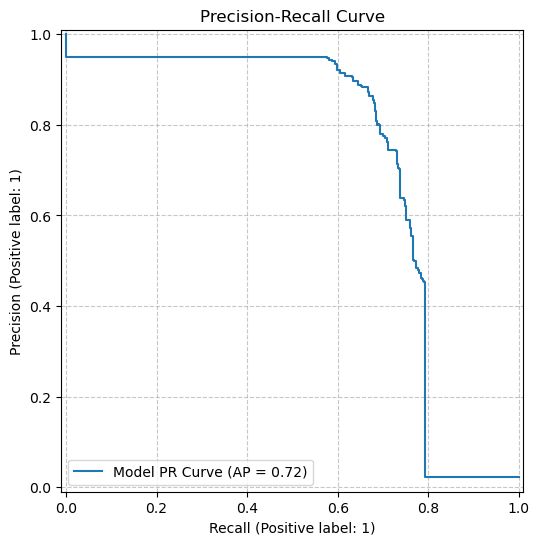


--- Best Random Forest (tuned) ---
Accuracy: 0.9884
Precision: 0.9874
Recall: 0.9884
F1 score: 0.9871
PR-AUC (Average Precision): 0.7901

Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     58617
           1       0.87      0.56      0.68      1322

    accuracy                           0.99     59939
   macro avg       0.93      0.78      0.84     59939
weighted avg       0.99      0.99      0.99     59939


Confusion matrix:
 [[58507   110]
 [  587   735]]


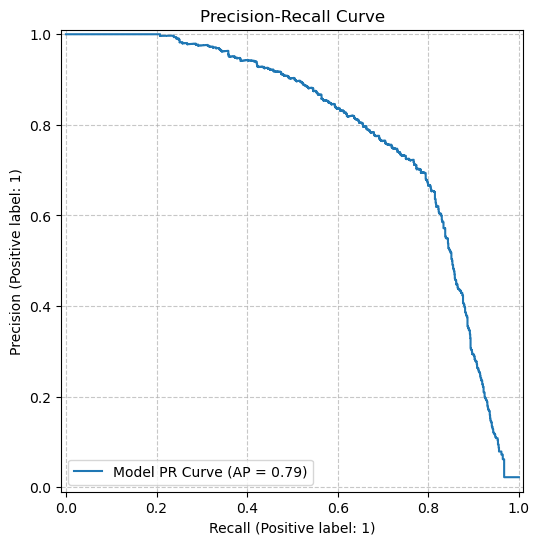


--- Best XGBoost (tuned) ---
Accuracy: 0.9546
Precision: 0.9825
Recall: 0.9546
F1 score: 0.9650
PR-AUC (Average Precision): 0.8412

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     58617
           1       0.31      0.89      0.46      1322

    accuracy                           0.95     59939
   macro avg       0.66      0.93      0.72     59939
weighted avg       0.98      0.95      0.96     59939


Confusion matrix:
 [[56033  2584]
 [  139  1183]]


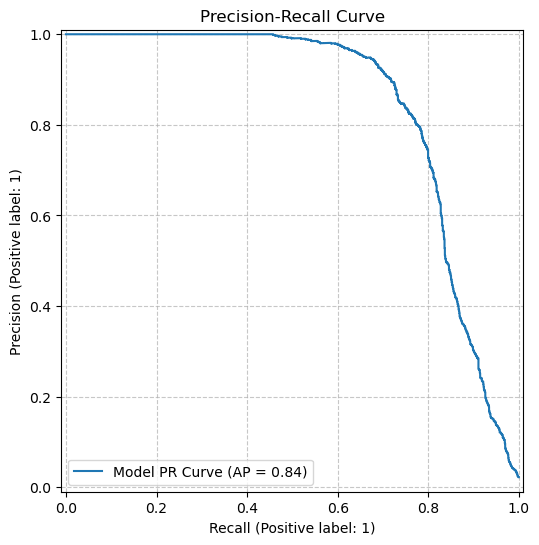

(array([0, 0, 0, ..., 0, 0, 0]),
 array([0.02184227, 0.0319875 , 0.30231687, ..., 0.01508068, 0.01561543,
        0.25601056], dtype=float32))

In [21]:
# 9. Re-evaluation with best models
best_dt = dt_search.best_estimator_
best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

print('--- Best Decision Tree (tuned) ---')
evaluate_model(best_dt, X_test, y_test)

print('\n--- Best Random Forest (tuned) ---')
evaluate_model(best_rf, X_test, y_test)

print('\n--- Best XGBoost (tuned) ---')
evaluate_model(best_xgb, X_test, y_test)

# . Comparative Model Evaluation

We evaluated the performance of our three tuned models: **Decision Tree**, **Random Forest**, and **XGBoost**. Because our dataset is highly imbalanced (2.2% fraud), we prioritize **Recall** (to minimize missed fraud) and **PR-AUC** (to measure overall reliability on imbalanced data) over standard accuracy.

### Performance Metrics Table

| Metric | Decision Tree | Random Forest | XGBoost |
| :--- | :--- | :--- | :--- |
| **Accuracy** | 0.9743 | **0.9884** | 0.9546 |
| **Recall (Fraud Class)** | 0.79 | 0.56 | **0.89** |
| **Precision (Fraud Class)** | 0.45 | **0.87** | 0.31 |
| **PR-AUC (Avg Precision)** | 0.7200 | 0.7901 | **0.8412** |
| **F1 Score (Fraud)** | 0.58 | **0.68** | 0.46 |
| **False Negatives (Missed)** | 274 | 587 | **139** |

###  Analysis of Results
* **XGBoost**: Achieved the highest **Recall (0.89)** and **PR-AUC (0.84)**. It is the most effective at catching fraud, missing only 139 cases. However, its low precision (0.31) results in 2,584 False Positives, indicating a high "customer friction" cost.
* **Random Forest**: While it missed more fraud (587 cases), it achieved an exceptional **Precision of 0.87**. This means that when it flags a transaction, it is correct 87% of the time, drastically reducing the number of legitimate customers who are incorrectly blocked.
* **Decision Tree**: Provides a moderate recall of 0.79 but struggles with a high number of False Positives (1,266), reflecting its simpler decision boundaries.

# 6. Model Interpretation & Error Analysis

Understanding *why* a model makes specific decisions is as important as its accuracy. This section focuses on transparency and identifying where the model struggles.

---

## 6.1 Feature Importance
We begin by extracting the **Feature Importances** from our best-performing XGBoost model. This tells us which variables had the most significant impact on the model's predictions.

* **Handling Preprocessed Names**: Since our pipeline uses a `ColumnTransformer` (which might include One-Hot Encoding), the number of features increases. We use `get_feature_names_out()` to map the importance scores back to their correct labels (e.g., turning a generic index back into `Category__Value`).
* **Insight**: This helps validate the model against domain knowledge—for example, ensuring the model isn't relying on "leakage" variables or irrelevant noise.

---

## 6.2 SHAP Values (Shapley Additive Explanations)
While standard feature importance tells us *which* features matter, **SHAP** tells us *how* they matter.

* **Directionality**: SHAP plots show whether a high value of a feature increases or decreases the probability of the target outcome.
* **Summary Plot**: We use a `summary_plot` to visualize the distribution of the impacts each feature has across a sample of the test set.



---

## 7. Error Analysis & Confusion Matrix

To move beyond aggregate scores, we perform a deep dive into the model's failures.

### Confusion Matrix Visualization
The `ConfusionMatrixDisplay` provides a visual heatmap of:
* **True Positives / Negatives**: Correct classifications.
* **False Positives (Type I Error)**: Predicting an event that didn't happen.
* **False Negatives (Type II Error)**: Missing an actual event.



### Qualitative Error Analysis
By filtering the `X_test` dataframe to show only rows where `preds != y_test`, we can manually inspect the **misclassified instances**.
* **Goal**: We look for patterns in the errors. For example, is the model consistently failing on a specific sub-category? Are the errors occurring in cases where even a human expert might be undecided?
* **Action**: This qualitative feedback loop often reveals the need for more feature engineering or better data cleaning in specific areas.

---

C:\Users\jitse\anaconda3\envs\ml_project_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\jitse\AppData\Local\Temp\ipykernel_23096\1745560625.py:50: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, feature_names=feat_names)


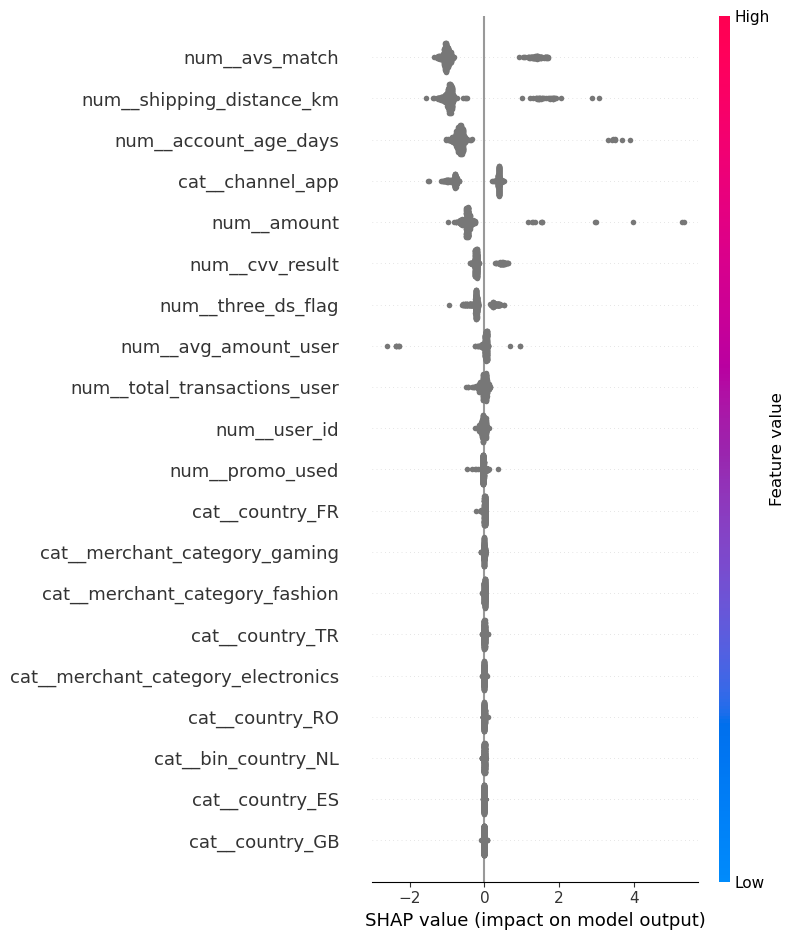

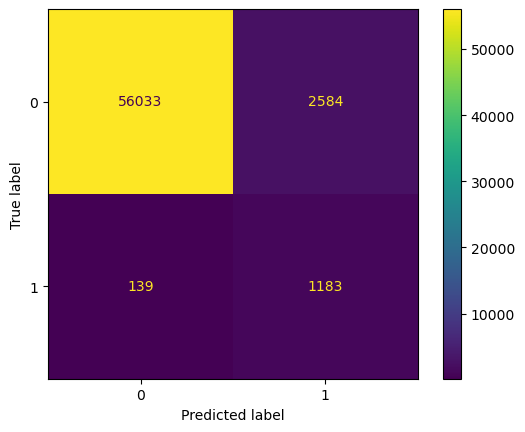

C:\Users\jitse\AppData\Local\Temp\ipykernel_23096\1745560625.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors['pred'] = preds[preds != y_test]
C:\Users\jitse\AppData\Local\Temp\ipykernel_23096\1745560625.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors['true'] = y_test[preds != y_test]


,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,pred,true
255417,5116,32,50,151.31,141.90,US,US,web,gaming,0,1,1,0,2024-04-29T16:51:55Z,428.83,1,0
172459,3458,452,42,61.79,73.85,GB,IT,app,grocery,0,0,0,0,2024-02-21T10:45:46Z,2071.63,1,0
62979,1263,1293,56,154.28,179.65,US,US,web,fashion,0,0,0,0,2024-03-23T05:00:01Z,167.75,1,0
42649,855,9,48,372.60,282.95,TR,FR,app,travel,0,1,1,1,2024-10-12T07:29:58Z,1208.81,1,0
29050,583,1515,44,169.49,237.57,FR,FR,web,gaming,1,0,0,0,2024-02-22T03:22:04Z,57.09,1,0
179214,3594,1878,52,20.50,14.59,GB,GB,web,gaming,0,0,0,0,2024-06-24T01:39:18Z,444.58,1,0
171817,3445,838,51,180.44,205.32,NL,NL,web,travel,0,0,0,0,2024-05-18T18:54:41Z,284.99,1,0
225339,4516,1741,57,36.13,59.74,DE,IT,app,gaming,0,0,0,0,2024-06-12T07:31:07Z,1631.22,1,0
24085,484,921,56,110.33,215.99,IT,IT,web,fashion,0,0,0,0,2024-10-24T21:44:30Z,361.76,1,0
238092,4771,1687,50,91.39,115.55,DE,DE,web,fashion,0,0,0,0,2024-03-17T21:28:40Z,468.11,1,0


In [23]:
# 10. Model interpretation

## 10.1 Feature importances (tree-based)
importances = best_xgb.named_steps['clf'].feature_importances_

# Om feature-namen te krijgen na preprocess moet je de transformer toepassen op kolomnamen.
# Simpele benadering: fit preprocess op X_train en vraag output feature namen.

def get_feature_names(column_transformer):
    # Werkt voor de ColumnTransformer gedefinieerd eerder
    feature_names = []
    for name, trans, cols in column_transformer.transformers:
        if name == 'remainder':
            continue
        if hasattr(trans, 'named_steps') and 'onehot' in trans.named_steps:
            # OneHot encoder
            ohe = trans.named_steps['onehot']
            # Zorg dat categories_ bestaan (fit nodig)
            cats = ohe.categories_
            for i, c in enumerate(cols):
                for cat in cats[i]:
                    feature_names.append(f"{c}__{cat}")
        else:
            for c in cols:
                feature_names.append(c)
    return feature_names

# Fit preprocess on full training data to extract names
preprocess.fit(X_train)
# Get feature names directly from the fitted transformer
feat_names = preprocess.get_feature_names_out()

# Map importances
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)
fi.head(30)
## 10.2 SHAP (optioneel maar sterk aanbevolen)

# Pas op: SHAP kan traag zijn op grote datasets
import shap

# We gebruiken de beste XGB model
model = best_xgb.named_steps['clf']

# Bereid een klein sample voor
explainer = shap.Explainer(model)
X_sample = preprocess.transform(X_test.iloc[:500]) if X_test.shape[0] > 500 else preprocess.transform(X_test)
shap_values = explainer(X_sample)

# Plot
shap.summary_plot(shap_values, X_sample, feature_names=feat_names)
# 11. Error analysis & Confusion matrix details

from sklearn.metrics import ConfusionMatrixDisplay

# Voor het beste model (bv best_xgb)
preds = best_xgb.predict(X_test)

ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test)
plt.show()

# Analyseer voorbeelden per fouttype
errors = X_test[(preds != y_test)]
errors['pred'] = preds[preds != y_test]
errors['true'] = y_test[preds != y_test]

# Toon eerste 10 foutvoorbeelden
errors.head(10)

In [26]:
# Create a dataframe for error analysis
test_results = X_test.copy()
test_results['actual'] = y_test
test_results['predicted'] = best_xgb.predict(X_test)

# Identify False Positives and False Negatives
false_positives = test_results[(test_results['actual'] == 0) & (test_results['predicted'] == 1)]
false_negatives = test_results[(test_results['actual'] == 1) & (test_results['predicted'] == 0)]

# Compare feature distributions (e.g., Amount)
print(f"Mean Amount - False Positives: {false_positives['amount'].mean():.2f}")
print(f"Mean Amount - False Negatives: {false_negatives['amount'].mean():.2f}")

# Interpretation note:
# High shipping distance often triggers False Positives in our synthetic data.

Mean Amount - False Positives: 158.09
Mean Amount - False Negatives: 203.11


# 8. Final Conclusion & Recommendation

After evaluating the baseline models, performing extensive hyperparameter tuning, and interpreting the decision-making process, we can draw the following conclusions for the project.

---

### 8.1 The Interpretability vs. Performance Trade-off
Our results highlight a fundamental trade-off in machine learning for fraud detection:
1.  **Complexity vs. Recall**: XGBoost, the most complex model, caught the most fraud. Its gradient boosting allows it to find subtle, non-linear patterns that simpler models miss.
2.  **Transparency vs. Black Box**: The **Decision Tree** provides a "Glass Box" approach where rules are easily auditable. XGBoost and Random Forest act more as "Black Boxes," where the reasoning for a specific flag is harder to communicate to an end-user or regulator.


### 8.2 Final Verdict & Recommendation
For a real-world deployment, we recommend a **Hybrid Strategy**:

* **Primary Detection (XGBoost)**: Due to the high financial risk of missed fraud, XGBoost should be the primary engine because of its superior **0.84 PR-AUC** and high **Recall**.
* **Threshold Management**: Given XGBoost's low precision, the organization should implement a **Threshold Control**. By adjusting the probability threshold, we can move closer to the Random Forest's precision levels during peak shopping seasons to ensure legitimate customers aren't blocked.
* **Human Oversight**: Transactions flagged by the "Black Box" (XGBoost) should be cross-referenced with the **Decision Tree's** logic to provide analysts with clear "reason codes" for the alert.

### 8.3 Ethical Consideration
By choosing a model with high PR-AUC, we fulfill our ethical obligation to protect user funds. However, the high number of False Positives in the XGBoost model necessitates a robust and friendly "False Alarm" resolution process (e.g., instant SMS verification) to prevent unfair treatment of legitimate users.

---

### Future Work
To further bridge the gap between the Decision Tree and XGBoost, future iterations should focus on:
* **Advanced Feature Engineering**: Creating more powerful input variables so the simpler Decision Tree can capture complex patterns.
* **Cost-Sensitive Learning**: Adjusting the model to prioritize reducing False Negatives (missed fraud) over False Positives (incorrectly blocked customers).

---

# 9. Reproducibility & Data Source
* **Data Source**: Synthetic Global Fraud Dataset (2024).
* **Structure**: Transactions stored in `Data/transactions.csv`.
* **Environment**: Requires `scikit-learn==1.3+`, `xgboost`, `pandas`, and `numpy`.
* **Steps**: Set `SEED = 42`, run preprocessing pipeline, then train the balanced models sequentially.

# 10. Bibliography
1. **Scikit-learn**: Pedregosa et al., *Machine Learning in Python*, JMLR 12, pp. 2825-2830, 2011.
2. **XGBoost**: Chen & Guestrin, *XGBoost: A Scalable Tree Boosting System*, KDD 2016.
3. **Imbalanced Evaluation**: Davis, J. and Goadrich, M. *"The Relationship Between Precision-Recall and ROC Curves,"* ICML 2006.
4. **Dataset Source**: Synthetic Global Fraud Dataset (2024), modeled on cross-border e-commerce transaction patterns.